# Data loader
data in /dds/workspace/data_ja/

In [ ]:
!ls /dds/workspace/data_ja/

### fonction de chargement d'image jpeg par morceau

In [75]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1e10
ImageFile.LOAD_TRUNCATED_IMAGES = True

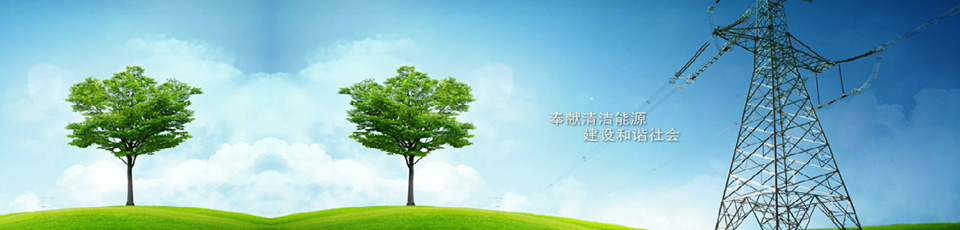

In [252]:
img_path = '/dds/workspace/data_ja/test.jpg'
img_pil = Image.open(img_path)
img_pil

In [307]:
def change_tile(tile, new_width, new_height, memory_offset):
    tup = tile[0]
    return [(tup[0],) + ((0,0,new_width, new_height),) + (tup[-2]+memory_offset,) + (tup[-1],)]

def read_line_portion(img_path,x,y,w,h,i):
    img_pil = Image.open(img_path)
    W = img_pil.size[0]
    img_pil.size=(w,1)
    memory_offset = (x+i)*3*W+3*y
    img_pil.tile = change_tile(img_pil.tile,w,1,memory_offset)
    #print(img_pil.tile)
    #print(img_pil.size)
    return img_pil

def read_from_memory(img_path,x,y,w,h):
    result = Image.new('RGB',(w,h))
    for i in range(h):
        a = read_line_portion(img_path, x,y,w,h,i)
        result.paste(a,(0,i))
    return result

def show_thumbnail(img_pil, max_size_thumbnail = 200):
    img_pil_thumbnail = img_pil.copy()
    size = img_pil.size
    max_size_img = float(max(size))
    new_size =  tuple((max_size_thumbnail/max_size_img*np.asarray(result.size)).astype(int))
    img_pil_thumbnail.thumbnail(new_size, Image.ANTIALIAS)
    return img_pil_thumbnail

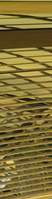

In [308]:
#(960, 230)
x = 100
y = 800
h = 2300
w = 600

img_path = '/dds/workspace/data_ja/cat.ppm'
result = read_from_memory(img_path,x,y,w,h)
show_thumbnail(result)
    


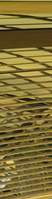

In [300]:
a.size

(200, 162)

In [301]:
result.size

(1600, 1300)

### conversion jpeg to ppm + extraction tile

In [65]:
from PIL import Image, ImageFile
import os
Image.MAX_IMAGE_PIXELS = 1e10
ImageFile.LOAD_TRUNCATED_IMAGES = True

def change_tile(tile, new_width, new_height):
    tup = tile[0]
    return [(tup[0],) + ((0,0,new_width, new_height),) + (tup[-2],) + (tup[-1],)]

image_path_in='/dds/workspace/data_ja/CAT_1_9013.jpg'
image_path_in='/dds/workspace/data_ja/test.jpg'
image_path_out=image_path_in[:-3]+"ppm"
os.system("convert "+image_path_in+" "+image_path_out)

image_pil = Image.open(image_path_out)
print("tile : ", image_pil.tile, " | size : ", image_pil.size)

tile :  [('raw', (0, 0, 960, 230), 15, ('RGB', 0, 1))]  | size :  (960, 230)


In [66]:
new_width,new_height = (960, 230)
new_width,new_height = (960, 130)
image_pil.tile = change_tile(image_pil.tile,new_width,new_height)
image_pil.size = (new_width, new_height)

In [67]:
image_pil.tile

[('raw', (0, 0, 960, 130), 15, ('RGB', 0, 1))]

In [68]:
image_pil.size

(960, 130)

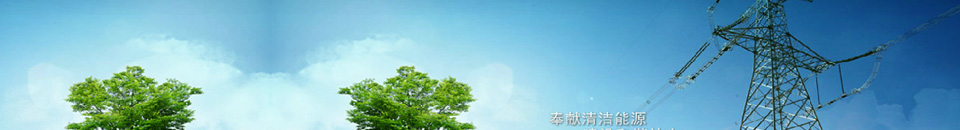

In [69]:
image_pil

## Images

## basic info

In [ ]:
from PIL import Image, ImageFile
Image.MAX_IMAGE_PIXELS = 1e10
ImageFile.LOAD_TRUNCATED_IMAGES = True
image_path='/dds/workspace/data_ja/CAT_1_9013.jpg'
#image_path='/dds/workspace/data_ja/CAT_1_9013.4.png'
# image_path='/dds/workspace/data_ja/test.jpg'
#image_path='/dds/workspace/data_ja/test.jpg.png'
#image_path='/dds/workspace/data_ja/test.jpg.2.png'
#image_path='/dds/workspace/data_ja/test.jpg.3.png'

### tile test

In [ ]:
image_path='/dds/workspace/data_ja/test.jp2'
i = Image.open(image_path)
print("tile : ", i.tile)

In [ ]:
i = Image.open(image_path)
w=96
h=10
i.size = (w, h)
i.tile = [('jpeg', (0, 0, w, h), 0, ('RGB', ''))]
i.load()

In [ ]:
i

In [ ]:
a

In [266]:
!python test_loader_pil_crop.py

(32792, 16396)
[('raw', (0, 0, 32792, 16396), 19, ('RGB', 0, 1))]
Filename: test_loader_pil_crop.py

Line #    Mem usage    Increment   Line Contents
    33     32.3 MiB      0.0 MiB   @profile
    34                             def my_func():
    35                                 #(960, 230)
    36     32.3 MiB      0.0 MiB       x = 100
    37     32.3 MiB      0.0 MiB       y = 800
    38     32.3 MiB      0.0 MiB       h = 30000
    39     32.3 MiB      0.0 MiB       w = 15000
    40   1748.8 MiB   1716.5 MiB       result = Image.new('RGB',(w,h))
    41   1748.8 MiB      0.0 MiB       img_path = '/dds/workspace/data_ja/cat.ppm'
    42   1750.5 MiB      1.7 MiB       i = Image.open(img_path)
    43   1750.5 MiB      0.0 MiB       print(i.size)
    44   1750.5 MiB      0.0 MiB       print(i.tile)
    45   1750.5 MiB      0.0 MiB       for i in range(h):
    46   1750.5 MiB      0.0 MiB           a = read_line_portion(img_path, x,y,w,h,i)
    47   1750.5 MiB      0.0 MiB           re

In [140]:
from memory_profiler import profile



from PIL import Image, ImageFile
Image.MAX_IMAGE_PIXELS = 1e10
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os


#ImageFile.LOAD_TRUNCATED_IMAGES = True
image_path='/dds/workspace/data_ja/CAT_1_9013.jpg'
#image_path='/dds/workspace/data_ja/CAT_1_9013.bmp'
image_path='/dds/workspace/data_ja/test.jp2'




image_path='/dds/workspace/data_ja/cat.ppm'


i = Image.open(image_path)
print(i.size)
print(i.tile)

#os.system("convert "+image_path+" "+image_path[-3:]+"ppm")

#return

##save 
#rgb_im = i.convert('RGB')
#i.save(image_path+'.3.png',optimize=False,compress_level=0)

## crop
#left = 100
#top = 100
#width = 200
#height = 100
#box = (left, top, left+width, top+height)
#i.crop(box)

#return



#i = Image.open(image_path)
w=100
h=100
i.size = (w, h)
#i.tile = [('jpeg', (0, 0, w, h), 0, ('RGB', ''))]
i.tile = [('raw', (0, 0, w, h), 19+000, ('RGB', 0, 1))]
print("Changing tile")
print(i.size)
print(i.tile)
i.load()
print(i.getextrema())



(32792, 16396)
[('raw', (0, 0, 32792, 16396), 19, ('RGB', 0, 1))]
Changing tile
(100, 100)
[('raw', (0, 0, 100, 100), 19, ('RGB', 0, 1))]
((150, 154), (126, 129), (47, 53))


In [138]:
i

ValueError: tile cannot extend outside image

<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=100x100 at 0x7F0C3BEC1B70>